In [4]:
 from google.colab import files
 # ZIP yükle
uploaded = files.upload()

# ZIP aç
import zipfile
import os

with zipfile.ZipFile("YOLO_format.zip", 'r') as zip_ref:
    zip_ref.extractall("YOLO_format")

Saving YOLO_format.zip to YOLO_format.zip


In [1]:
!pip install torch torchvision



In [5]:
# 🗃️ Gerekli kütüphaneler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import os
import time

# 🔍 AffectNet YOLO Format Dataset Sınıfı
class AffectNetYOLODataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform

        if not os.path.exists(self.image_dir):
            raise FileNotFoundError(f"Image directory not found: {self.image_dir}")
        if not os.path.exists(self.label_dir):
            raise FileNotFoundError(f"Label directory not found: {self.label_dir}")

        self.image_files = [f for f in os.listdir(self.image_dir)
                            if os.path.splitext(f)[-1].lower() in ['.jpg', '.jpeg', '.png']]
        if len(self.image_files) == 0:
            print(f"Warning: No image files found in {image_dir}.")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_filename = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_filename)
        base_name = os.path.splitext(image_filename)[0]
        label_path = os.path.join(self.label_dir, base_name + ".txt")

        image = Image.open(image_path).convert("RGB")

        if not os.path.exists(label_path):
            raise FileNotFoundError(f"Label file not found: {label_path}")

        with open(label_path, "r") as f:
            line = f.readline().strip()
            if not line:
                raise ValueError(f"Label file is empty: {label_path}")
            class_id = int(line.split()[0])

        if self.transform:
            image = self.transform(image)

        return image, class_id

# 🔧 Model oluşturma (ResNet34 + Full Fine-tune)
def get_resnet34_model(num_classes=8):
    model = models.resnet34(weights='DEFAULT')
    for param in model.parameters():
        param.requires_grad = True
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, num_classes)
    )
    return model

# 🔁 Dönüşümler
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2, 0.2, 0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# 📂 Veri yolları
train_dataset = AffectNetYOLODataset(
    image_dir="YOLO_format/YOLO_format/train/images",
    label_dir="YOLO_format/YOLO_format/train/labels",
    transform=train_transform
)
val_dataset = AffectNetYOLODataset(
    image_dir="YOLO_format/YOLO_format/valid/images",
    label_dir="YOLO_format/YOLO_format/valid/labels",
    transform=val_transform
)

# 📦 DataLoader'lar
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=2)

print(f"Train: {len(train_dataset)} görüntü | Val: {len(val_dataset)} görüntü")

# 🖥️ Cihaz
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Kullanılan cihaz:", device)

# 🧠 Model, Loss, Optimizer, Scheduler
model = get_resnet34_model(num_classes=8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# 🔁 Eğitim döngüsü
num_epochs = 40
best_val_acc = 0.0
start = time.time()

for epoch in range(num_epochs):
    print(f"\n🚀 Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        if batch_idx % 100 == 0:
            print(f"  Batch {batch_idx}/{len(train_loader)}")
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    avg_loss = running_loss / len(train_loader)

    # 🔍 Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = 100 * val_correct / val_total
    print(f"[{epoch+1}] Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_resnet34_emotion.pth")
        print(f"💾 Yeni en iyi model kaydedildi! Val Acc: {val_acc:.2f}%")

    scheduler.step()

elapsed = time.time() - start
print(f"\n✅ Eğitim tamamlandı! Süre: {elapsed/60:.2f} dakika")

# 📥 Modeli indir
from google.colab import files
files.download("best_resnet34_emotion.pth")


Train: 17101 görüntü | Val: 5406 görüntü
Kullanılan cihaz: cuda


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 94.0MB/s]



🚀 Epoch 1/40
  Batch 0/535
  Batch 100/535
  Batch 200/535
  Batch 300/535
  Batch 400/535
  Batch 500/535
[1] Loss: 1.3203 | Train Acc: 51.28% | Val Acc: 60.03%
💾 Yeni en iyi model kaydedildi! Val Acc: 60.03%

🚀 Epoch 2/40
  Batch 0/535
  Batch 100/535
  Batch 200/535
  Batch 300/535
  Batch 400/535
  Batch 500/535
[2] Loss: 1.0242 | Train Acc: 62.68% | Val Acc: 62.75%
💾 Yeni en iyi model kaydedildi! Val Acc: 62.75%

🚀 Epoch 3/40
  Batch 0/535
  Batch 100/535
  Batch 200/535
  Batch 300/535
  Batch 400/535
  Batch 500/535
[3] Loss: 0.8940 | Train Acc: 67.25% | Val Acc: 67.41%
💾 Yeni en iyi model kaydedildi! Val Acc: 67.41%

🚀 Epoch 4/40
  Batch 0/535
  Batch 100/535
  Batch 200/535
  Batch 300/535
  Batch 400/535
  Batch 500/535
[4] Loss: 0.8081 | Train Acc: 70.25% | Val Acc: 66.35%

🚀 Epoch 5/40
  Batch 0/535
  Batch 100/535
  Batch 200/535
  Batch 300/535
  Batch 400/535
  Batch 500/535
[5] Loss: 0.7464 | Train Acc: 72.94% | Val Acc: 68.76%
💾 Yeni en iyi model kaydedildi! Val Acc: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
# 📥 Modeli indir
from google.colab import files
files.download("best_resnet34_emotion.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [7]:
model.eval()
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())


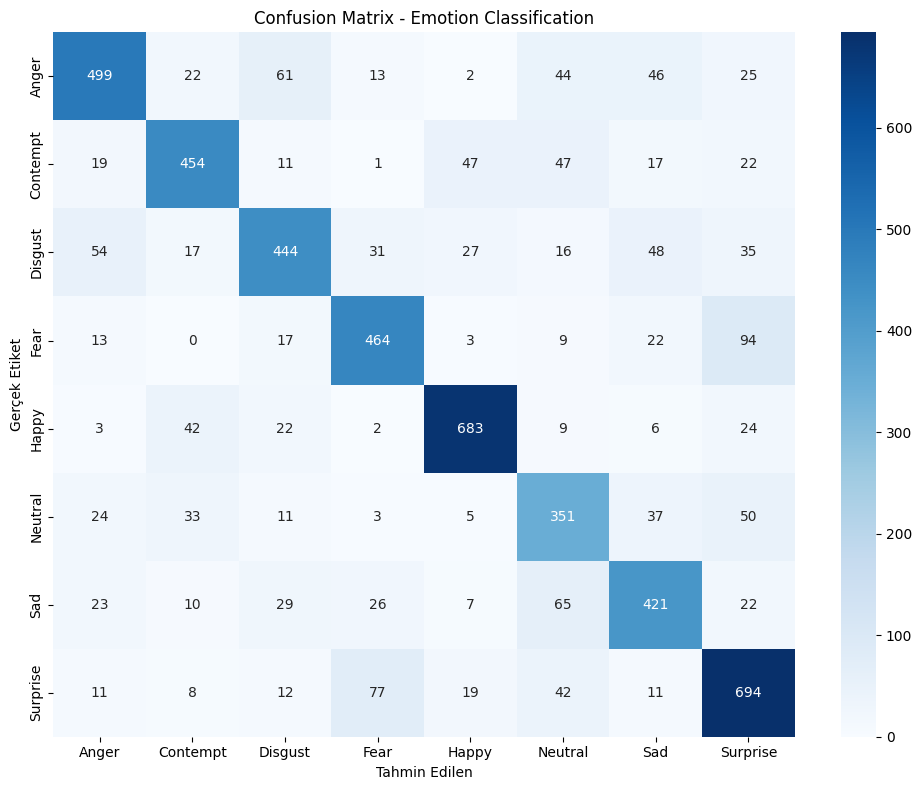

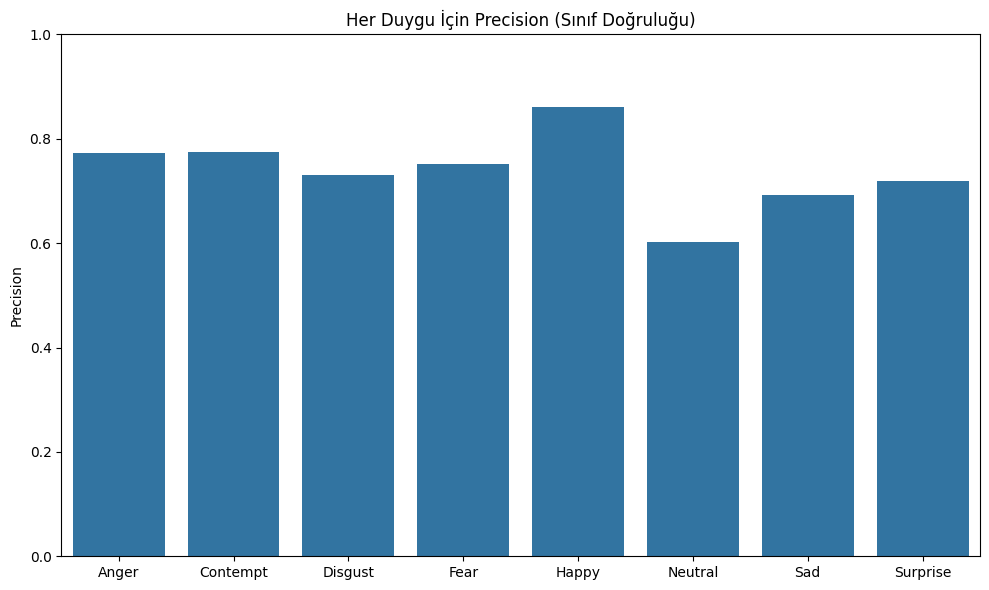

In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

class_names = ["Anger", "Contempt", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

# Confusion matrix
conf_mat = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Etiket")
plt.title("Confusion Matrix - Emotion Classification")
plt.tight_layout()
plt.show()

# Precision (sınıf doğrulukları)
report = classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=True)
precision_per_class = [report[cls]["precision"] for cls in class_names]

plt.figure(figsize=(10, 6))
sns.barplot(x=class_names, y=precision_per_class)
plt.ylabel("Precision")
plt.ylim(0, 1)
plt.title("Her Duygu İçin Precision (Sınıf Doğruluğu)")
plt.tight_layout()
plt.show()


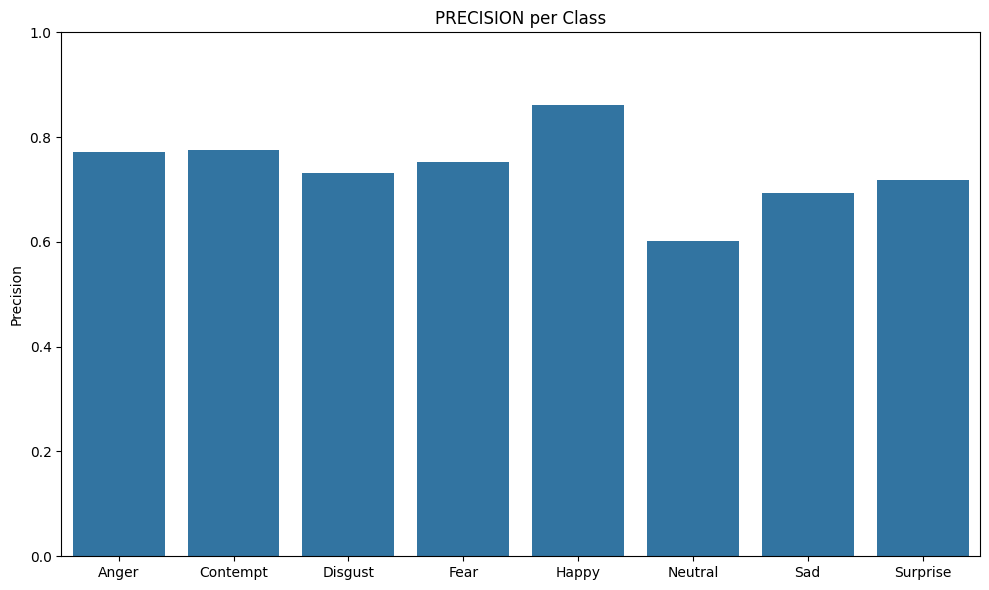

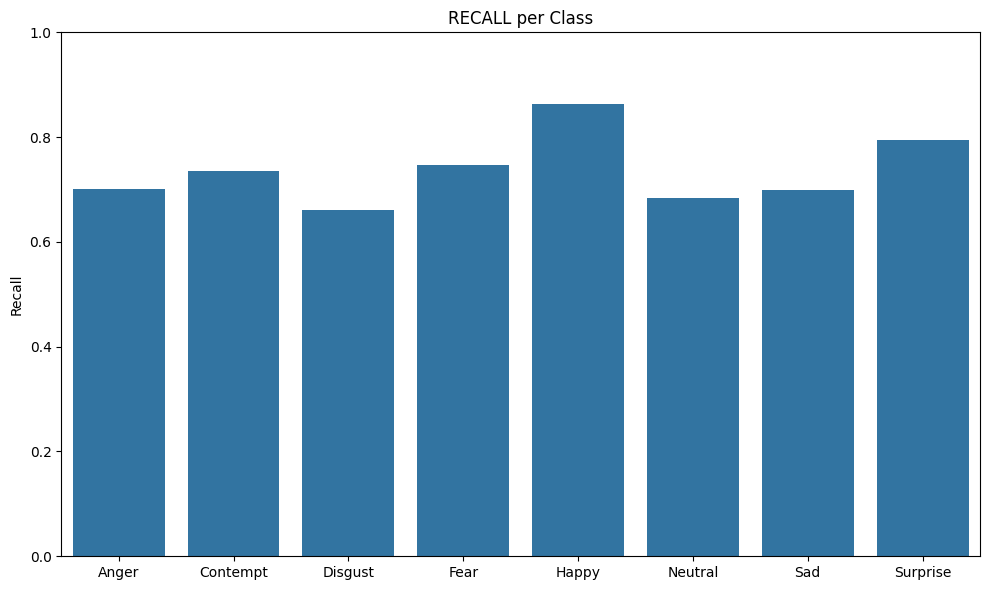

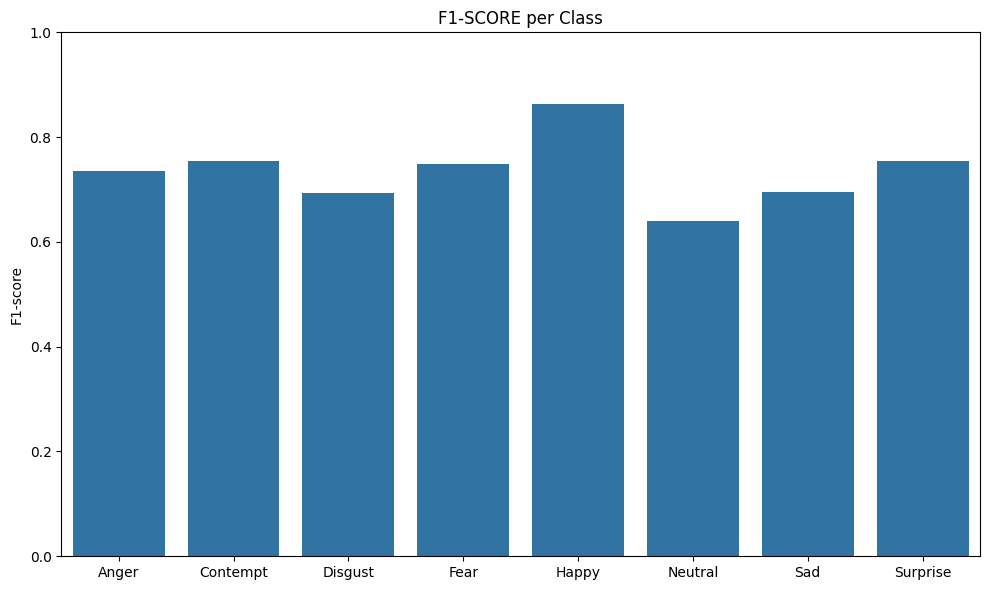

In [9]:
report = classification_report(true_labels, predicted_labels, target_names=class_names, output_dict=True)

metrics = ['precision', 'recall', 'f1-score']
for metric in metrics:
    values = [report[cls][metric] for cls in class_names]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_names, y=values)
    plt.title(f"{metric.upper()} per Class")
    plt.ylim(0, 1)
    plt.ylabel(metric.capitalize())
    plt.tight_layout()
    plt.show()


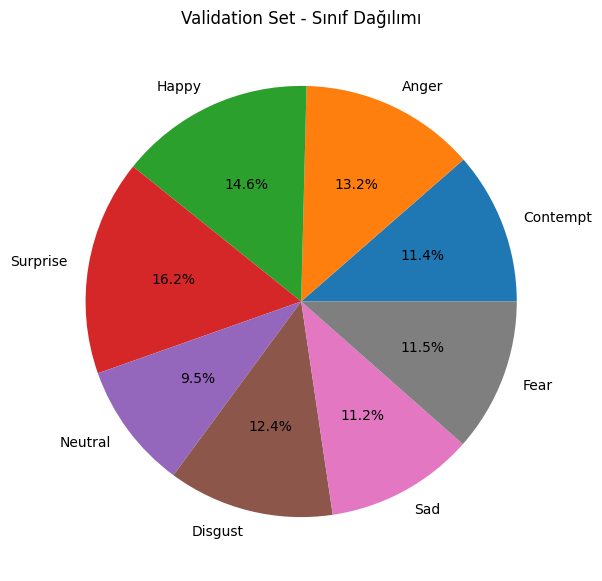

In [11]:
import collections

counts = collections.Counter(true_labels)
plt.figure(figsize=(7, 7))
plt.pie(counts.values(), labels=[class_names[i] for i in counts.keys()], autopct='%1.1f%%')
plt.title("Validation Set - Sınıf Dağılımı")
plt.show()


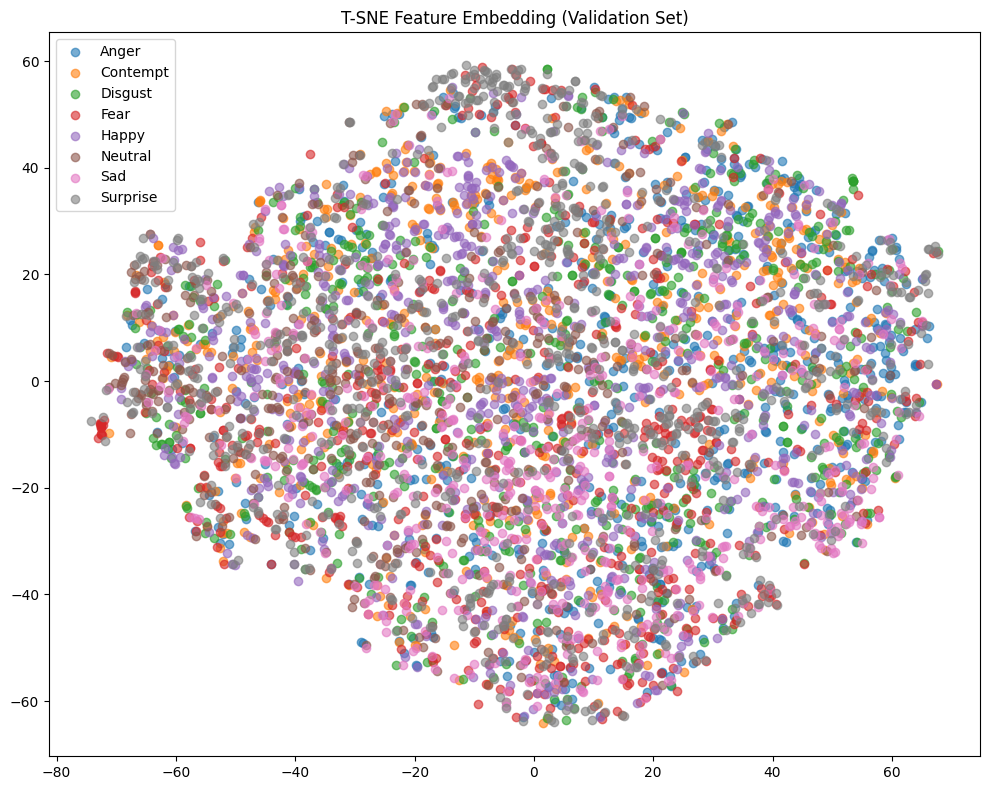

In [13]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

features = []
labels = []

model.eval()
with torch.no_grad():
    for images, lbls in val_loader:
        images = images.to(device)
        lbls = lbls.to(device)
        x = model.avgpool(model.layer4(model.layer3(model.layer2(model.layer1(model.relu(model.bn1(model.conv1(images))))))))
        x = torch.flatten(x, 1)
        features.append(x.cpu())
        labels.append(lbls.cpu())

features = torch.cat(features).numpy()
labels = torch.cat(labels).numpy()

tsne = TSNE(n_components=2, random_state=42).fit_transform(features)

plt.figure(figsize=(10, 8))
for i, name in enumerate(class_names):
    idxs = labels == i
    plt.scatter(tsne[idxs, 0], tsne[idxs, 1], label=name, alpha=0.6)

plt.legend()
plt.title("T-SNE Feature Embedding (Validation Set)")
plt.tight_layout()
plt.show()
